# Computing Meridional Overturning

Meriodional Overturning Circulation is a key diagnostic for ocean circulation. This notebook demonstrate how to compute various flavors of it using the [xoverturning](https://github.com/raphaeldussin/xoverturning) package.

In [1]:
import xarray as xr # requires >= 0.15.1
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

Load the sample dataset and geolon/geolat from static file (without holes on eliminated processors). Note that this is working for both symetric and non-symetric grids but the dataset and grid file must be consistent.

In [4]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, engine='pydap')

In [5]:
dsgrid = xr.open_dataset('./data/ocean_grid_nonsym_OM4_05.nc')

## A first overturning computation

In [6]:
from xoverturning import calcmoc

This computes the meridional overturning circulation (moc) on the whole ocean:

In [7]:
moc = calcmoc(ds, dsgrid=dsgrid)

generating basin codes


The result is given at the vertical interfaces since the streamfunction is the result of the integration of transports over layers and on the q-point because V-velocities are located on (xh, yq) and integrated over the x-axis.

In [8]:
moc

,Array,Chunk
Bytes,4.98 MB,82.94 kB
Shape,"(60, 36, 576)","(1, 36, 576)"
Count,30727 Tasks,60 Chunks
Type,float32,numpy.ndarray


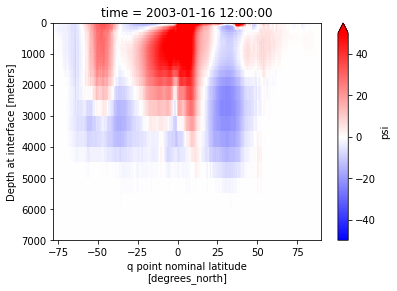

In [9]:
moc.sel(time='2003-01').plot(vmin=-50,vmax=50, yincrease=False, cmap='bwr')

## MOC and Basins

xoverturning can compute the MOC over a specified basin. Default is `basin='global'`, but pre-defined available options are `basin='atl-arc'` and `basin='indopac'`. If the grid file contain a basin DataArray produced by [cmip_basins](https://github.com/jkrasting/cmip_basins), it will use it in combination with predefined basin codes to create the basin mask. If the array does not exist, xoverturning will generate it on-the-fly using cmip_basin code. It is also possible to use an arbitrary list of basin codes as argument to `basin`, which could be particularly handy if you have custom build basin codes.

In [11]:
# atlantic
amoc = calcmoc(ds, dsgrid=dsgrid, basin='atl-arc')

generating basin codes


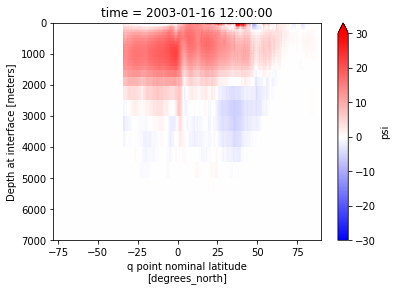

In [12]:
amoc.sel(time='2003-01').plot(vmin=-30,vmax=30, yincrease=False, cmap='bwr')

In [13]:
# indopacific
pmoc = calcmoc(ds, dsgrid=dsgrid, basin='indopac')

generating basin codes


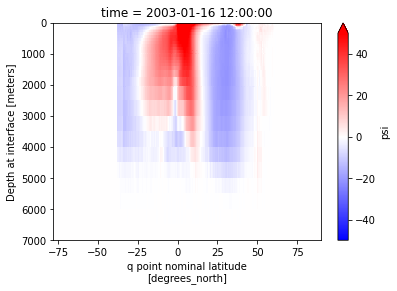

In [14]:
pmoc.sel(time='2003-01').plot(vmin=-50,vmax=50, yincrease=False, cmap='bwr')

## Masking (only in geopotential coordinates)

You can also mask out the ocean floor to make it more plot-friendly with `mask_output`.

generating basin codes


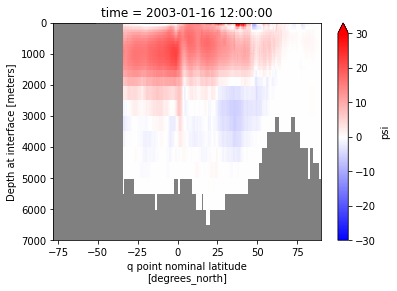

In [15]:
amoc = calcmoc(ds, dsgrid=dsgrid, basin='atl-arc', mask_output=True)
amoc.sel(time='2003-01').plot(vmin=-30,vmax=30, yincrease=False, cmap='bwr', 
                              subplot_kws={'facecolor': 'grey'})

## Density coordinates

Because xoverturning is written in a non-specific vertical coordinate system, it can also compute the MOC in other coordinates system, such as the `rho2` output by using the `vertical='rho2'` option.

In [16]:
pproot = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20201120/'
run = 'CM4_piControl_c96_OM4p25_half_kdadd'
ppdir = f'{pproot}/{run}/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2'

ds_rho2 = xr.open_mfdataset([f"{ppdir}/ts/annual/10yr/ocean_annual_rho2.0021-0030.umo.nc",
                        f"{ppdir}/ts/annual/10yr/ocean_annual_rho2.0021-0030.vmo.nc"])

dsgrid_rho2 = xr.open_dataset(f"{ppdir}/ocean_annual_rho2.static.nc")

In [17]:
amoc_rho2 = calcmoc(ds_rho2, dsgrid=dsgrid_rho2, vertical='rho2', basin='atl-arc')

generating basin codes


In [18]:
amoc_rho2

<xarray.DataArray 'psi' (time: 10, rho2_i: 36, yq: 1081)>
dask.array<truediv, shape=(10, 36, 1081), dtype=float32, chunksize=(10, 36, 1081), chunktype=numpy.ndarray>
Coordinates:
  * rho2_i   (rho2_i) float64 999.5 1.028e+03 1.029e+03 ... 1.037e+03 1.038e+03
  * time     (time) object 0021-07-02 12:00:00 ... 0030-07-02 12:00:00
  * yq       (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.68 89.78 89.89 90.0

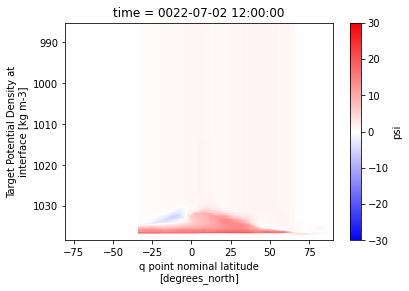

In [19]:
amoc_rho2.sel(time='0022-07').plot(vmin=-30,vmax=30, yincrease=False, cmap='bwr')

## Derived quantities

Since the output of xoverturning is a xarray.DataArray, computing derived quantities is a breeze thanks to xarray built-in functions:

In [20]:
maxmoc_atl = amoc.max(dim=['yq', 'z_i'])

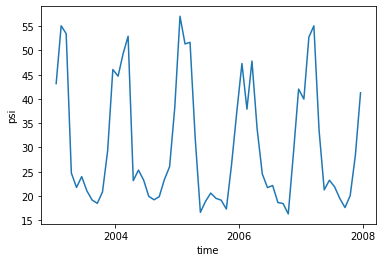

In [21]:
maxmoc_atl.plot()

In [22]:
maxmoc_atl = amoc.sel(yq=slice(20.0, 80.0), z_i=slice(500.0, 2500.0)).max(dim=['yq', 'z_i'])

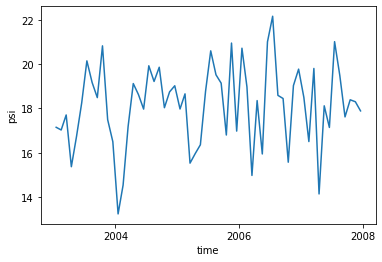

In [23]:
maxmoc_atl.plot()

## Misc options

xoverturning also have more specialized options such as `remove_hml` that is used to remove the signal ov `vhml` and a `rotate` option attempting to rotate to true north. This latest option is still in progress and will be updated. 